In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as mplt
from sklearn import svm
import itertools
import numpy as np
import csv
import cv2
import os
print(cv2.__version__)
# set matplotlib to print inline (Jupyter)
%matplotlib inline

pth = 'images/'
pth_train = 'training_set/'
pth_test = 'testing_set/'

refactor = False

# pokemon selection

3.2.0


In [2]:
# Functions

def csvRead(file, filepth=pth, delimiter=','):
    with open(filepth + file, newline='') as csv_file:
        csv_data = csv.reader(csv_file, delimiter=delimiter)
        return list(csv_data)[1:]
    
def getContours(contours):
    mins_x, mins_y = list(), list()
    maxs_x, maxs_y = list(), list()
    for contour in contours:
        cnt = [c[0] for c in contour]
        cnt_x = [c[0] for c in cnt]
        cnt_y = [c[1] for c in cnt]
        mins_x.append(min(cnt_x))
        mins_y.append(min(cnt_y))
        maxs_x.append(max(cnt_x))
        maxs_y.append(max(cnt_y))

    dists_x = [ma-mi for ma, mi in zip(maxs_x, mins_x)]
    dists_y = [ma-mi for ma, mi in zip(maxs_y, mins_y)]

    areas = [x*y for x, y in zip(dists_x, dists_y)]
    index_of_largest = areas.index(max(areas))

    w = maxs_x[index_of_largest] - mins_x[index_of_largest]
    h = maxs_y[index_of_largest] - mins_y[index_of_largest]

    top_left_point = (mins_x[index_of_largest], mins_y[index_of_largest])
    bottom_right_point = (maxs_x[index_of_largest], maxs_y[index_of_largest])

    x, y = top_left_point[0], top_left_point[1]
    w, h = bottom_right_point[0] - top_left_point[0], bottom_right_point[1] - top_left_point[1]
    return (x, y, w, h)

def readRGB(img_pth):
    img = cv2.imread(img_pth)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def getDescriptionHarris(img_rgb):
    res = np.zeros((40000,))
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    dst = cv2.cornerHarris(gray, 3, 1, 0.04)
    dst = dst.flatten()
    dst = np.where(dst != 0)[0]
    dst = dst[0: dst.shape[0]: 50]
    
    res[0: dst.shape[0]] += dst
    return res

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=mplt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    mplt.imshow(cm, interpolation='nearest', cmap=cmap)
    mplt.title(title)
    mplt.colorbar()
    tick_marks = np.arange(len(classes))
    mplt.xticks(tick_marks, classes, rotation=45)
    mplt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        mplt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    mplt.tight_layout()
    mplt.ylabel('True label')
    mplt.xlabel('Predicted label')
    
def getDescription(img_rgb, pokemon=''):
    # hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    img_rgb = np.where(img_rgb == [255, 255, 255], [0, 0, 0], img_rgb)
    lims = list(range(0, 251, 50)) 

    # Get the channels
    h_ch = img[:, :, 0]
    s_ch = img[:, :, 1]
    v_ch = img[:, :, 2]
    
    bins = range(0, 230)
    hist_h, _ = np.histogram(h_ch, bins=bins)
    hist_s, _ = np.histogram(s_ch, bins=bins)
    hist_v, _ = np.histogram(v_ch, bins=bins)
    
    hist_h = hist_h[0: -1]
    hist_s = hist_s[0: -1]
    hist_v = hist_v[0: -1]
    
    rmax_idx_h = np.sum(hist_h * np.arange(1, len(hist_h) + 1)) / np.sum(hist_h)
    rmax_idx_s = np.sum(hist_s * np.arange(1, len(hist_s) + 1)) / np.sum(hist_s)
    rmax_idx_v = np.sum(hist_v * np.arange(1, len(hist_v) + 1)) / np.sum(hist_v)
    
    max_idx_h = lims[[abs(i - rmax_idx_h) for i in lims].index(min([abs(i - rmax_idx_h) for i in lims]))]
    max_idx_s = lims[[abs(i - rmax_idx_s) for i in lims].index(min([abs(i - rmax_idx_s) for i in lims]))]
    max_idx_v = lims[[abs(i - rmax_idx_v) for i in lims].index(min([abs(i - rmax_idx_v) for i in lims]))]
    
    description = [max_idx_h, max_idx_s, max_idx_v]
    
    return description

In [3]:
if refactor:
    # Image refactoring
    # Get all pokemon directories
    pokemons = list(os.walk(pth_test))[0][1]

    # Convert all images to jpg
    for pokemon in pokemons:
        full_pth = pth + pokemon + '/'
        for image in os.listdir(full_pth):
            img = cv2.imread(full_pth + image, cv2.IMREAD_GRAYSCALE)
            img_color = cv2.imread(full_pth + image)
            ret, thresh = cv2.threshold(img,220,255,cv2.THRESH_BINARY_INV)
            _, contours, _ = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            
            box = getContours(contours)
            max_idx = box.index(max([box[2], box[3]]))
            min_idx = box.index(min([box[2], box[3]]))
            
            img_color = img_color[box[1]: box[1] + box[max_idx], box[0]: box[0] + box[max_idx]]
            
            img_f = np.zeros((box[max_idx], box[max_idx], 3), dtype=np.uint8)
            img_f += 255
            
            left_x = box[max_idx] // 2 - img_color.shape[1] // 2
            left_y = box[max_idx] // 2 - img_color.shape[0] // 2
            
            img_f[left_y: left_y + img_color.shape[0], left_x: left_x + img_color.shape[1]] = img_color
            
            height, width = 200, 200
            img_f = cv2.resize(img_f, (width, height), interpolation = cv2.INTER_CUBIC)
            
            cv2.imwrite(full_pth + '200x200' + image, img_f)

In [4]:
# Get the descriptions from the train dataset of pokemons
pokemons = list(os.walk(pth_train))[0][1]
pokemon_descriptors = {k: [] for k in pokemons}

for pokemon in pokemons:
    full_pth = pth_train + pokemon + '/'
    for image in os.listdir(full_pth):
        img = readRGB(full_pth + image)
        description = getDescription(img, pokemon=pokemon)
        # print(image[7: -3], description)

        pokemon_descriptors[pokemon].append(description)

# Create the classifier
classifier = svm.SVC()

# Create the data matrix for training,
# obtain matrix dimensions

dim_y = sum([len(pokemon_descriptors[pokemon]) for pokemon in pokemon_descriptors.keys()])
dim_x = len(pokemon_descriptors[pokemons[0]][0])
X = np.zeros((dim_y, dim_x))
y = list()

count = 0
for pokemon in pokemons:
    for instance in pokemon_descriptors[pokemon]:
        if count // 79 != (count - 1) // 79:
            print(pokemon, instance)
        X[count] = np.array(instance)
        y.append(pokemon)
        count += 1

classifier.fit(X, y)

# Get crossvalidation performance
score = cross_val_score(classifier, X, y, cv=10)
print(score.mean(), score.std()*2)

haunter [150, 150, 150]
oddish [150, 150, 100]
poliwrath [100, 150, 150]
charizard [150, 100, 100]
pikachu [150, 150, 50]
0.946950549451 0.0754083397455


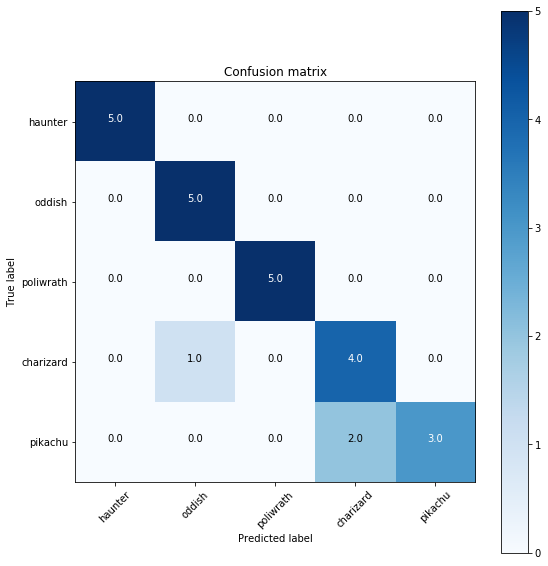

In [5]:
# Test the classifier
img_pth = pth_test
pokemons = list(os.walk(img_pth))[0][1]
pokemon_descriptors = {k: [] for k in pokemons}
pokemon_counter = {k: 0 for k in pokemons}

results = np.zeros((len(pokemons), len(pokemons)))
for pokemon in pokemons:
    pokemon_counter = {k: 0 for k in pokemons}
    full_pth = img_pth + pokemon + '/'
    for image in os.listdir(full_pth):
        img = readRGB(full_pth + image)
        description = getDescription(img)
        
        # Classifier prediction
        prediction = classifier.predict([description])[0]
        pokemon_counter[prediction] += 1
        results[pokemons.index(pokemon)][pokemons.index(prediction)] += 1
        print(image[7: -3], prediction)
    
mplt.figure(figsize=(8, 8))
plot_confusion_matrix(results, classes=pokemons, title='Confusion matrix')